# Análise de Objetos Relacionados - Predição de Votos Parlamentares

Este notebook implementa uma metodologia de engenharia de características baseada em **objetos relacionados** para predição de votos parlamentares na Câmara dos Deputados, seguindo o padrão estabelecido em `authors_popularity.ipynb`.

## Objetivo

Desenvolver e avaliar características preditivas baseadas no histórico de aprovação de proposições relacionadas, testando diferentes janelas temporais para otimizar a performance de modelos de machine learning.

## Metodologia

### 1. **Conceito de Objetos Relacionados**
- Identifica proposições que aparecem juntas nas mesmas sessões de votação
- Calcula taxa de aprovação histórica de proposições relacionadas
- Utiliza janelas temporais deslizantes para capturar padrões recentes

### 2. **Engenharia de Características**
- **`related_objects_approval_rate`**: Taxa de aprovação de proposições relacionadas em sessões anteriores
- **`related_objects_total_sessions`**: Número total de sessões com proposições relacionadas no período
- **Múltiplas janelas temporais**: 1, 2, 3, 4, 5 e 10 sessões anteriores

### 3. **Avaliação de Performance**
- **Métricas para dados desbalanceados**: AUROC, AUPRC, Balanced Accuracy, MCC
- **Foco na classe minoritária**: Predição de rejeições (aprovacao=0)
- **Validação temporal**: Split cronológico preservando ordem temporal
- **Modelos testados**: Random Forest e Logistic Regression com balanceamento de classes

## Dados Utilizados

### Dataset Principal
- **`vote_sessions_full.csv`**: 9.260 sessões de votação (2003-2024)
- **171 características**: Incluindo informações de partidos, blocos e orientações
- **Taxa de aprovação**: 79,5% (dados desbalanceados)

### Dataset de Objetos
- **`votacoesObjetos-{ano}.csv`**: 688.474 registros de objetos de votação
- **Período**: 2003-2024 (22 anos)
- **Mapeamento**: Relaciona sessões de votação com proposições específicas

## Principais Análises

1. **Carregamento e Preparação**: Consolidação de dados de múltiplas fontes
2. **Feature Engineering**: Cálculo de características baseadas em objetos relacionados
3. **Avaliação de Janelas**: Teste de 6 configurações de janela temporal
4. **Análise de Performance**: Comparação de métricas para dados desbalanceados
5. **Análise de Regras Simples**: Implementação de regras de predição sem ML

## Resultados Esperados

- **Identificação da melhor janela temporal** para objetos relacionados
- **Métricas de performance** otimizadas para dados desbalanceados
- **Comparação com baseline** e outras abordagens
- **Dataset final** com características de objetos relacionados

## Observações Importantes

- **Dados desbalanceados**: 79,5% de aprovações vs 20,5% de rejeições
- **Validação temporal**: Crucial para evitar data leakage
- **Baixo overlap**: Apenas 1 proposição em comum entre datasets (0,0%)
- **Foco em rejeições**: Métricas otimizadas para predição da classe minoritária


In [31]:
import pandas as pd
import os

# Import the dataset
voting_sessions = pd.read_csv('../data/vote_sessions_full.csv')

# Remove duplicated ids
voting_sessions = voting_sessions.drop_duplicates(subset=['id'])

# Display basic information about the dataset
print("Dataset shape:", voting_sessions.shape)
print("\nColumn names:")
print(voting_sessions.columns.tolist())
print("\nFirst few rows:")
voting_sessions.head()


Dataset shape: (9260, 171)

Column names:
['id', 'uri', 'data', 'idOrgao', 'siglaOrgao', 'aprovacao', 'descricao', 'ultimaAberturaVotacao_descricao', 'ultimaApresentacaoProposicao_descricao', 'year', 'propositionID', 'proposicao_siglaTipo', 'idVotacao', 'AVANTE', 'Avante', 'Bl MdbPsdRepPode', 'Bl MdbPsdRepPodePsc', 'Bl UniPpFdrPsdbCid...', 'Bloco Parlamentar', 'CIDADANIA', 'Cidadania', 'DEM', 'Fdr PSDB-CIDADAN', 'Fdr PSDB-CIDADANIA', 'Fdr PSOL-REDE', 'Fdr PT-PCdoB-PV', 'GOV.', 'Governo', 'MDB', 'MINORIA', 'Maioria', 'Minoria', 'NOVO', 'Novo', 'NovoCidPv', 'Oposição', 'PATRI', 'PATRIOTA', 'PCdoB', 'PDT', 'PEN', 'PFL', 'PFL/PRONA', 'PHS', 'PL', 'PL/PSL', 'PMB', 'PMDB', 'PMN', 'PMR', 'PODE', 'PP', 'PPB', 'PPL', 'PPS', 'PR', 'PRB', 'PRD', 'PRONA', 'PROS', 'PRP', 'PRTB', 'PSB', 'PSC', 'PSD', 'PSDB', 'PSDC', 'PSL', 'PSOL', 'PT', 'PTB', 'PTC', 'PTN', 'PTdoB', 'PV', 'Patriota', 'PdtAvante', 'PdtPodePros...', 'PdtPros...', 'PdtSdPode...', 'PmdbPen', 'PmdbPpDemPsbPdtPodePcdobPscPhsAvantePen', 'P

,id,uri,data,idOrgao,siglaOrgao,aprovacao,descricao,ultimaAberturaVotacao_descricao,ultimaApresentacaoProposicao_descricao,year,...,União,idProposicao_x,author_type,author,author_type_code,idDeputadoAutor,num_authors,idProposicao_y,theme,legislatura
0,96076-49,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-02-19,180,PLEN,1.0,Aprovada a Redação Final oferecida pelo Relato...,Votação da Redação Final.,"Parecer Proferido em Plenário, Dep. Luiz Eduar...",2003,...,0,96076.0,Órgão do Poder Executivo,Poder Executivo,30000.0,NaN,2,96076.0,Esporte e Lazer,52
1,96076-46,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-02-19,180,PLEN,1.0,Aprovado o Substitutivo oferecido pelo Relator...,Votação em turno único.,"Parecer Proferido em Plenário, Dep. Luiz Eduar...",2003,...,0,96076.0,Órgão do Poder Executivo,Poder Executivo,30000.0,NaN,2,96076.0,Esporte e Lazer,52
2,90170-30,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-02-26,180,PLEN,1.0,"Aprovado requerimento do Líderes que requer, n...",NaN,Apresentação do Requerimento.,2003,...,0,90170.0,Órgão do Poder Executivo,Poder Executivo,30000.0,NaN,4,90170.0,Defesa e Segurança,52
3,101651-2,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-02-26,180,PLEN,1.0,Aprovado,NaN,Apresentação do Requerimento.,2003,...,0,90170.0,Órgão do Poder Executivo,Poder Executivo,30000.0,NaN,4,90170.0,Defesa e Segurança,52
4,90170-25,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-02-27,180,PLEN,1.0,Aprovada a Redação Final oferecida pelo Relato...,Votação da Redação Final,"Parecer Proferido em Plenário, Dep. Agnaldo Mu...",2003,...,0,90170.0,Órgão do Poder Executivo,Poder Executivo,30000.0,NaN,4,90170.0,Defesa e Segurança,52


In [32]:
# Define the path pattern for the voting objects CSV files
data_path = "../../data/voting/object/votacoesObjetos-{year}.csv"

# List to store all dataframes
all_dataframes = []

# Loop through years from 2003 to 2024
for year in range(2003, 2025):
    file_path = data_path.format(year=year)
    
    # Check if file exists
    if os.path.exists(file_path):
        print(f"Loading data for year {year}...")
        
        # Read CSV with semicolon separator (as shown in the sample)
        df = pd.read_csv(file_path, sep=';')
        
        # Add year column for reference
        df['year'] = year
        
        # Append to list
        all_dataframes.append(df)
    else:
        print(f"File not found for year {year}: {file_path}")

# Combine all dataframes into one
if all_dataframes:
    voting_objects = pd.concat(all_dataframes, ignore_index=True)
    print(f"\nCombined dataset shape: {voting_objects.shape}")
    print("\nFirst few rows:")
    voting_objects.head()
else:
    print("No data files found!")


Loading data for year 2003...
Loading data for year 2004...
Loading data for year 2005...
Loading data for year 2006...
Loading data for year 2007...
Loading data for year 2008...
Loading data for year 2009...
Loading data for year 2010...
Loading data for year 2011...
Loading data for year 2012...
Loading data for year 2013...
Loading data for year 2014...
Loading data for year 2015...
Loading data for year 2016...
Loading data for year 2017...
Loading data for year 2018...
Loading data for year 2019...
Loading data for year 2020...
Loading data for year 2021...
Loading data for year 2022...
Loading data for year 2023...
Loading data for year 2024...

Combined dataset shape: (688474, 13)

First few rows:


In [33]:
voting_objects

,idVotacao,uriVotacao,data,descricao,proposicao_id,proposicao_uri,proposicao_ementa,proposicao_codTipo,proposicao_siglaTipo,proposicao_numero,proposicao_ano,proposicao_titulo,year
0,105529-3,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-03-19,"Aprovado o Requerimento, com a sugestão do Dep...",105529,https://dadosabertos.camara.leg.br/api/v2/prop...,"Requerem, nos termos regimentais, que a Comiss...",147,REQ,2.0,2003.0,REQ 2/2003 CDHM,2003
1,105530-3,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-03-19,Aprovado o Requerimento,105530,https://dadosabertos.camara.leg.br/api/v2/prop...,"Requer, nos termos regimentais, a realização d...",147,REQ,3.0,2003.0,REQ 3/2003 CDHM,2003
2,105531-3,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-03-19,Aprovado o Requerimento,105531,https://dadosabertos.camara.leg.br/api/v2/prop...,"Requerem, nos termos regimentais (art.29), a c...",147,REQ,4.0,2003.0,REQ 4/2003 CDHM,2003
3,105532-3,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-03-19,"Aprovado o Requerimento, com a denominação de ...",105532,https://dadosabertos.camara.leg.br/api/v2/prop...,"Requerem, nos termos regimentais (art. 29), a ...",147,REQ,5.0,2003.0,REQ 5/2003 CDHM,2003
4,105643-4,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-03-19,Aprovado o Requerimento,105643,https://dadosabertos.camara.leg.br/api/v2/prop...,"Requer, nos termos regimentais, seja convidado...",147,REQ,7.0,2003.0,REQ 7/2003 CDHM,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
688469,384954-62,https://dadosabertos.camara.leg.br/api/v2/vota...,2024-12-19,"Aprovado o requerimento nº 4990/2024,do Sr. El...",388549,https://dadosabertos.camara.leg.br/api/v2/prop...,Contra decisão do Presidente da Comissão de Co...,459,REC,153.0,2008.0,REC 153/2008 => PEC 233/2008,2024
688470,384954-62,https://dadosabertos.camara.leg.br/api/v2/vota...,2024-12-19,"Aprovado o requerimento nº 4990/2024,do Sr. El...",390471,https://dadosabertos.camara.leg.br/api/v2/prop...,Requer com fulcro no art. 142 do Regimento Int...,304,REQ,2578.0,2008.0,REQ 2578/2008 => PEC 31/2007,2024
688471,389981-40,https://dadosabertos.camara.leg.br/api/v2/vota...,2024-12-19,"Aprovado o requerimento nº 4990/2024,do Sr. El...",392409,https://dadosabertos.camara.leg.br/api/v2/prop...,Requer apensação à Pec nº 031-A/2007.,304,REQ,2632.0,2008.0,REQ 2632/2008 => PEC 31/2007,2024
688472,391353-29,https://dadosabertos.camara.leg.br/api/v2/vota...,2024-12-19,"Aprovado o requerimento nº 4990/2024,do Sr. El...",391353,https://dadosabertos.camara.leg.br/api/v2/prop...,"Revoga a alínea ""a"" do inciso I e acrescenta p...",136,PEC,248.0,2008.0,PEC 248/2008,2024


In [34]:
# Let's first understand the data structure better
print("Voting Sessions Dataset:")
print(f"Shape: {voting_sessions.shape}")
print(f"Date range: {voting_sessions['data'].min()} to {voting_sessions['data'].max()}")
print(f"Unique propositionIDs: {voting_sessions['propositionID'].nunique()}")
print(f"Approval rate: {voting_sessions['aprovacao'].mean():.3f}")

print("\nVoting Objects Dataset:")
print(f"Shape: {voting_objects.shape}")
print(f"Date range: {voting_objects['data'].min()} to {voting_objects['data'].max()}")
print(f"Unique proposicao_ids: {voting_objects['proposicao_id'].nunique()}")

# Check overlap between propositionID and proposicao_id
overlap = set(voting_sessions['propositionID'].dropna()) & set(voting_objects['proposicao_id'].dropna())
print(f"\nOverlap between datasets: {len(overlap)} propositions")
print(f"Percentage of voting_sessions propositions found in voting_objects: {len(overlap)/voting_sessions['propositionID'].nunique()*100:.1f}%")


Voting Sessions Dataset:
Shape: (9260, 171)
Date range: 2003-02-19 to 2024-12-19
Unique propositionIDs: 2118
Approval rate: 0.795

Voting Objects Dataset:
Shape: (688474, 13)
Date range: 2003-03-19 to 2024-12-19
Unique proposicao_ids: 275581

Overlap between datasets: 1 propositions
Percentage of voting_sessions propositions found in voting_objects: 0.0%


In [35]:
import numpy as np
from sklearn.metrics import roc_auc_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Prepare the data
# Convert dates to datetime
voting_sessions['data'] = pd.to_datetime(voting_sessions['data'])
voting_objects['data'] = pd.to_datetime(voting_objects['data'])

# Sort voting_sessions by date to ensure chronological order
voting_sessions_sorted = voting_sessions.sort_values('data').reset_index(drop=True)

# Create a mapping from voting session ID to propositions in voting_objects
voting_objects_map = voting_objects.groupby('idVotacao')['proposicao_id'].apply(set).to_dict()

print("Data preparation completed!")
print(f"Sorted voting sessions shape: {voting_sessions_sorted.shape}")
print(f"Voting objects mapping created with {len(voting_objects_map)} voting sessions")


Data preparation completed!
Sorted voting sessions shape: (9260, 171)
Voting objects mapping created with 148117 voting sessions


In [36]:
# OPTIMIZED FUNCTIONS FOLLOWING AUTHORS_POPULARITY PATTERN
print("=== RELATED OBJECTS FEATURE ENGINEERING FUNCTIONS ===")

def calculate_previous_approval_rate_optimized(data, window_size):
    """
    OPTIMIZED: Calculate the approval rate of previous voting sessions that contain the same propositionID.
    
    Parameters:
    - data: sorted dataframe of voting sessions
    - window_size: number of previous sessions to look at
    
    Returns:
    - approval_rates: list of approval rates for each session
    """
    approval_rates = []
    n_sessions = len(data)
    
    print(f"Processing {n_sessions:,} sessions for window size {window_size}...")
    
    for i in range(n_sessions):
        current_prop_id = data.iloc[i]['propositionID']
        
        # If propositionID is NaN, set approval rate to default (0.5 neutral)
        if pd.isna(current_prop_id):
            approval_rates.append(0.5)  # Use neutral instead of NaN for better model performance
            continue
        
        # Look at previous sessions within the window (optimized approach)
        start_idx = max(0, i - window_size)
        related_approvals = []
        
        # Efficiently check previous sessions
        for prev_idx in range(start_idx, i):
            prev_session_id = data.iloc[prev_idx]['id']
            
            # Check if this previous session has related objects
            if prev_session_id in voting_objects_map:
                related_props = voting_objects_map[prev_session_id]
                
                # Check if current propositionID is in the related objects
                if current_prop_id in related_props:
                    related_approvals.append(data.iloc[prev_idx]['aprovacao'])
        
        # Calculate approval rate
        if len(related_approvals) > 0:
            approval_rate = np.mean(related_approvals)
        else:
            approval_rate = 0.5  # Default to neutral when no history available
        
        approval_rates.append(approval_rate)
        
        # Progress indicator
        if (i + 1) % 5000 == 0:
            print(f"  Progress: {i + 1:,}/{n_sessions:,} sessions ({(i + 1)/n_sessions*100:.1f}%)")
    
    return approval_rates

def create_related_objects_features(data, window_config):
    """
    Create related objects features for all rows using specified window configuration.
    Following the same pattern as authors_popularity.ipynb
    
    Args:
        data: DataFrame with voting sessions
        window_config: Dictionary specifying the window size and name
    
    Returns:
        DataFrame with added related objects features
    """
    result_df = data.copy()
    
    print(f"Creating features for {window_config['name']}...")
    
    # Calculate approval rates for this window size
    approval_rates = calculate_previous_approval_rate_optimized(data, window_config['window_size'])
    
    # Add to dataframe with consistent naming
    result_df['related_objects_approval_rate'] = approval_rates
    result_df['related_objects_total_sessions'] = [
        sum(1 for j in range(max(0, i - window_config['window_size']), i) 
            if data.iloc[j]['id'] in voting_objects_map and 
               not pd.isna(data.iloc[i]['propositionID']) and
               data.iloc[i]['propositionID'] in voting_objects_map.get(data.iloc[j]['id'], set()))
        for i in range(len(data))
    ]
    
    print(f"Feature engineering completed for {window_config['name']}!")
    return result_df

# Define window configurations to test (following authors_popularity pattern)
window_configurations = [
    {'name': 'Last 1 Session', 'window_size': 1},
    {'name': 'Last 2 Sessions', 'window_size': 2},
    {'name': 'Last 3 Sessions', 'window_size': 3},
    {'name': 'Last 4 Sessions', 'window_size': 4},
    {'name': 'Last 5 Sessions', 'window_size': 5},
    {'name': 'Last 10 Sessions', 'window_size': 10}
]

print("Optimized functions defined successfully!")
print(f"Defined {len(window_configurations)} window configurations:")
for config in window_configurations:
    print(f"  - {config['name']} (window_size: {config['window_size']})")


=== RELATED OBJECTS FEATURE ENGINEERING FUNCTIONS ===
Optimized functions defined successfully!
Defined 6 window configurations:
  - Last 1 Session (window_size: 1)
  - Last 2 Sessions (window_size: 2)
  - Last 3 Sessions (window_size: 3)
  - Last 4 Sessions (window_size: 4)
  - Last 5 Sessions (window_size: 5)
  - Last 10 Sessions (window_size: 10)


In [37]:
# EVALUATION FRAMEWORK FOLLOWING AUTHORS_POPULARITY PATTERN
print("=== EVALUATION FRAMEWORK (OPTIMIZED FOR IMBALANCED DATA) ===")

# Import additional metrics for imbalanced data evaluation
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

def evaluate_window_performance_related_objects(df_with_features, window_name, test_size=0.2, random_state=42):
    """
    Evaluate the predictive performance of related objects features for a specific window size.
    Following the same pattern as authors_popularity.ipynb
    
    Args:
        df_with_features: DataFrame with related objects features
        window_name: Name of the window configuration being tested
        test_size: Proportion of data to use for testing
        random_state: Random seed for reproducibility
    
    Returns:
        Dictionary with performance metrics optimized for imbalanced data
    """
    print(f"\nEvaluating {window_name}...")
    
    # CLEAN DATA: Remove rows with NaN values in target variable
    clean_df = df_with_features.dropna(subset=['aprovacao']).copy()
    print(f"  Removed {len(df_with_features) - len(clean_df):,} rows with missing target values")
    
    if len(clean_df) == 0:
        print(f"  ERROR: No valid data after cleaning for {window_name}")
        return {'window_name': window_name, 'error': 'no_valid_data'}
    
    # Prepare features and target
    features = ['related_objects_approval_rate', 'related_objects_total_sessions']
    X = clean_df[features].fillna(0.5)  # Fill missing values with neutral
    y = clean_df['aprovacao']
    
    # Additional validation: ensure target has valid values
    if y.isna().any():
        print(f"  ERROR: Target still contains NaN values after cleaning")
        return {'window_name': window_name, 'error': 'nan_in_target'}
    
    # Check if we have both classes
    unique_classes = y.unique()
    if len(unique_classes) < 2:
        print(f"  ERROR: Only one class present: {unique_classes}")
        return {'window_name': window_name, 'error': 'single_class'}
    
    # Split data chronologically (time-aware split)
    split_date = clean_df['data'].quantile(1 - test_size)
    train_mask = clean_df['data'] < split_date
    test_mask = clean_df['data'] >= split_date
    
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    
    # Final validation on splits
    if len(X_train) == 0 or len(X_test) == 0:
        print(f"  ERROR: Empty train or test set after split")
        return {'window_name': window_name, 'error': 'empty_split'}
    
    if len(y_train.unique()) < 2 or len(y_test.unique()) < 2:
        print(f"  WARNING: One of the splits has only one class")
        # Continue anyway, but note this in results
    
    # Check class distribution
    train_approval_rate = y_train.mean()
    test_approval_rate = y_test.mean()
    
    print(f"  Training set: {len(X_train):,} samples (Approval rate: {train_approval_rate:.3f})")
    print(f"  Test set: {len(X_test):,} samples (Approval rate: {test_approval_rate:.3f})")
    print(f"  Rejected proposals (minority class): Train={len(y_train[y_train==0]):,}, Test={len(y_test[y_test==0]):,}")
    
    # Train models with class balancing
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100, 
            random_state=random_state, 
            max_depth=5,
            class_weight='balanced'
        ),
        'Logistic Regression': LogisticRegression(
            random_state=random_state, 
            max_iter=1000,
            class_weight='balanced'
        )
    }
    
    results = {'window_name': window_name}
    
    for model_name, model in models.items():
        print(f"  Training {model_name} (with balanced class weights)...")
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calculate IMBALANCED DATA METRICS
        if y_pred_proba is not None:
            auroc = roc_auc_score(y_test, y_pred_proba)
            auprc = average_precision_score(y_test, y_pred_proba)
        else:
            auroc = 0.5
            auprc = test_approval_rate
        
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        
        # Metrics for rejection prediction (minority class)
        precision_rejection = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
        recall_rejection = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
        f1_rejection = f1_score(y_test, y_pred, pos_label=0, zero_division=0)
        
        # Traditional metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # Store results
        results[f'{model_name}_auroc'] = auroc
        results[f'{model_name}_auprc'] = auprc
        results[f'{model_name}_balanced_accuracy'] = balanced_acc
        results[f'{model_name}_mcc'] = mcc
        results[f'{model_name}_precision_rejection'] = precision_rejection
        results[f'{model_name}_recall_rejection'] = recall_rejection
        results[f'{model_name}_f1_rejection'] = f1_rejection
        results[f'{model_name}_accuracy'] = accuracy
        results[f'{model_name}_f1_weighted'] = f1_weighted
        
        # Print key metrics
        print(f"    {model_name} - AUROC: {auroc:.3f}, AUPRC: {auprc:.3f}")
        print(f"    {model_name} - Balanced Acc: {balanced_acc:.3f}, MCC: {mcc:.3f}")
        print(f"    {model_name} - Rejection F1: {f1_rejection:.3f}, Rejection Recall: {recall_rejection:.3f}")
        
        # Feature importance for Random Forest
        if model_name == 'Random Forest' and hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            print(f"    Feature Importance:")
            for i, feature in enumerate(features):
                print(f"      {feature}: {importance[i]:.3f}")
    
    return results

def run_related_objects_methodology(voting_sessions_df, max_samples=None):
    """
    Run the complete window size methodology evaluation for related objects.
    
    Args:
        voting_sessions_df: DataFrame with voting sessions
        max_samples: Maximum number of samples to use (for faster testing)
    
    Returns:
        DataFrame with comparison results
    """
    print("=== RUNNING COMPLETE RELATED OBJECTS WINDOW SIZE METHODOLOGY ===")
    
    # Limit dataset size for faster computation if specified
    if max_samples and len(voting_sessions_df) > max_samples:
        print(f"Limiting dataset to {max_samples:,} most recent samples for faster computation...")
        df_sample = voting_sessions_df.tail(max_samples).copy()
    else:
        df_sample = voting_sessions_df.copy()
    
    print(f"Working with {len(df_sample):,} samples")
    
    all_results = []
    
    # Test each window configuration
    for i, config in enumerate(window_configurations):
        print(f"\n{'='*60}")
        print(f"TESTING CONFIGURATION {i+1}/{len(window_configurations)}: {config['name']}")
        print(f"{'='*60}")
        
        # Create features for this window configuration
        df_with_features = create_related_objects_features(df_sample, config)
        
        # Evaluate performance
        results = evaluate_window_performance_related_objects(df_with_features, config['name'])
        all_results.append(results)
        
        # Save intermediate results
        checkpoint_file = f"checkpoint_related_objects_{config['name'].lower().replace(' ', '_')}.csv"
        df_with_features.to_csv(checkpoint_file, index=False)
        print(f"  Saved checkpoint: {checkpoint_file}")
    
    # Create results comparison DataFrame
    results_df = pd.DataFrame(all_results)
    
    return results_df

# Execute the methodology
print("Executing Related Objects Window Size Methodology...")
results_comparison = run_related_objects_methodology(voting_sessions_sorted, max_samples=30000)  # Use subset for faster execution


=== EVALUATION FRAMEWORK (OPTIMIZED FOR IMBALANCED DATA) ===
Executing Related Objects Window Size Methodology...
=== RUNNING COMPLETE RELATED OBJECTS WINDOW SIZE METHODOLOGY ===
Working with 9,260 samples

TESTING CONFIGURATION 1/6: Last 1 Session
Creating features for Last 1 Session...
Processing 9,260 sessions for window size 1...
  Progress: 5,000/9,260 sessions (54.0%)
Feature engineering completed for Last 1 Session!

Evaluating Last 1 Session...
  Removed 346 rows with missing target values
  Training set: 7,130 samples (Approval rate: 0.778)
  Test set: 1,784 samples (Approval rate: 0.863)
  Rejected proposals (minority class): Train=1,586, Test=244
  Training Random Forest (with balanced class weights)...
    Random Forest - AUROC: 0.500, AUPRC: 0.863
    Random Forest - Balanced Acc: 0.500, MCC: 0.000
    Random Forest - Rejection F1: 0.000, Rejection Recall: 0.000
    Feature Importance:
      related_objects_approval_rate: 0.000
      related_objects_total_sessions: 0.000
 

In [38]:
# RESULTS ANALYSIS FOLLOWING AUTHORS_POPULARITY PATTERN
print("\n" + "="*80)
print("RESULTS COMPARISON ACROSS ALL WINDOW SIZES")
print("FOCUS: IMBALANCED DATA METRICS (ESPECIALLY REJECTION PREDICTION)")
print("="*80)

# Handle potential errors in results
print(f"Total configurations tested: {len(results_comparison)}")

# Check for any errors
error_rows = results_comparison[results_comparison.apply(lambda x: 'error' in x.values, axis=1)]
if len(error_rows) > 0:
    print(f"\nWARNING: {len(error_rows)} configurations had errors:")
    for idx, row in error_rows.iterrows():
        error_type = row.get('error', 'unknown')
        print(f"  - {row['window_name']}: {error_type}")
    
    # Remove error rows for analysis
    results_comparison = results_comparison[~results_comparison.apply(lambda x: 'error' in x.values, axis=1)]
    print(f"Proceeding with {len(results_comparison)} valid configurations")

if len(results_comparison) == 0:
    print("ERROR: No valid results to analyze!")
    print("Please check the data preprocessing and feature engineering steps.")
else:
    # Sort results by AUROC (best metric for imbalanced data)
    results_comparison = results_comparison.sort_values('Random Forest_auroc', ascending=False)

    print("\nPerformance Ranking (sorted by Random Forest AUROC - best for imbalanced data):")
    print("-" * 90)
    for idx, row in results_comparison.iterrows():
        print(f"{row['window_name']:20} | RF AUROC: {row['Random Forest_auroc']:.3f} | LR AUROC: {row['Logistic Regression_auroc']:.3f}")

    print("\nRejection Prediction Performance (Minority Class - aprovacao=0):")
    print("-" * 90)
    for idx, row in results_comparison.iterrows():
        print(f"{row['window_name']:20} | RF Rejection F1: {row['Random Forest_f1_rejection']:.3f} | LR Rejection F1: {row['Logistic Regression_f1_rejection']:.3f}")

    print("\nBalanced Accuracy Performance (Accounts for Class Imbalance):")
    print("-" * 90)
    for idx, row in results_comparison.iterrows():
        print(f"{row['window_name']:20} | RF Bal.Acc: {row['Random Forest_balanced_accuracy']:.3f} | LR Bal.Acc: {row['Logistic Regression_balanced_accuracy']:.3f}")

    print("\nDetailed Results (All Metrics):")
    print(results_comparison.round(3))

    # Save complete results
    results_comparison.to_csv('related_objects_window_comparison_results.csv', index=False)
    print(f"\nComplete results saved to: related_objects_window_comparison_results.csv")

    # Analysis and Recommendations
    print("\n" + "="*80)
    print("ANALYSIS AND RECOMMENDATIONS (IMBALANCED DATA FOCUS)")
    print("="*80)

    best_window = results_comparison.iloc[0]
    print(f"\nBEST PERFORMING WINDOW (by AUROC): {best_window['window_name']}")
    print(f"Random Forest AUROC: {best_window['Random Forest_auroc']:.3f}")
    print(f"Logistic Regression AUROC: {best_window['Logistic Regression_auroc']:.3f}")

    # Focus on rejection prediction performance
    print(f"\nREJECTION PREDICTION PERFORMANCE (Minority Class):")
    print(f"Random Forest - Rejection F1: {best_window['Random Forest_f1_rejection']:.3f}")
    print(f"Random Forest - Rejection Recall: {best_window['Random Forest_recall_rejection']:.3f}")
    print(f"Logistic Regression - Rejection F1: {best_window['Logistic Regression_f1_rejection']:.3f}")
    print(f"Logistic Regression - Rejection Recall: {best_window['Logistic Regression_recall_rejection']:.3f}")

    # Calculate performance statistics
    rf_auroc_scores = results_comparison['Random Forest_auroc']
    lr_auroc_scores = results_comparison['Logistic Regression_auroc']

    print(f"\nPERFORMANCE STATISTICS (IMBALANCED DATA METRICS):")
    print(f"Random Forest AUROC - Mean: {rf_auroc_scores.mean():.3f}, Std: {rf_auroc_scores.std():.3f}")
    print(f"Logistic Regression AUROC - Mean: {lr_auroc_scores.mean():.3f}, Std: {lr_auroc_scores.std():.3f}")

    # Find best window for specific metrics
    best_rejection_f1 = results_comparison.loc[results_comparison['Random Forest_f1_rejection'].idxmax()]
    best_mcc = results_comparison.loc[results_comparison['Random Forest_mcc'].idxmax()]
    best_balanced_acc = results_comparison.loc[results_comparison['Random Forest_balanced_accuracy'].idxmax()]

    print(f"\nPERFORMANCE PATTERNS:")
    print(f"Best for rejection prediction (F1): {best_rejection_f1['window_name']} (F1: {best_rejection_f1['Random Forest_f1_rejection']:.3f})")
    print(f"Best for overall correlation (MCC): {best_mcc['window_name']} (MCC: {best_mcc['Random Forest_mcc']:.3f})")
    print(f"Best for balanced accuracy: {best_balanced_acc['window_name']} (Bal.Acc: {best_balanced_acc['Random Forest_balanced_accuracy']:.3f})")

    print(f"\nRECOMMENDATIONS FOR RELATED OBJECTS FEATURE:")
    print(f"1. Primary recommendation: Use '{best_window['window_name']}' for optimal related objects prediction")
    print(f"   - Achieved highest AUROC of {best_window['Random Forest_auroc']:.3f}")

    if best_window['Random Forest_auroc'] > 0.7:
        print(f"   - AUROC > 0.7 indicates good discrimination ability")
    elif best_window['Random Forest_auroc'] > 0.6:
        print(f"   - AUROC > 0.6 indicates fair discrimination ability")
    else:
        print(f"   - AUROC < 0.6 indicates limited discrimination ability")

    if best_window['Random Forest_auroc'] > best_window['Logistic Regression_auroc']:
        print(f"2. Random Forest outperformed Logistic Regression")
    else:
        print(f"2. Logistic Regression outperformed Random Forest")

    print(f"3. This feature measures the approval rate of previous sessions that voted on related propositions")
    print(f"4. The feature provides temporal information about proposition topic success patterns")
    print(f"5. Consider combining this with other features for improved prediction performance")

    print("\n" + "="*80)
    print("RELATED OBJECTS METHODOLOGY EXECUTION COMPLETED SUCCESSFULLY!")
    print("="*80)



RESULTS COMPARISON ACROSS ALL WINDOW SIZES
FOCUS: IMBALANCED DATA METRICS (ESPECIALLY REJECTION PREDICTION)
Total configurations tested: 6

Performance Ranking (sorted by Random Forest AUROC - best for imbalanced data):
------------------------------------------------------------------------------------------
Last 1 Session       | RF AUROC: 0.500 | LR AUROC: 0.500
Last 2 Sessions      | RF AUROC: 0.500 | LR AUROC: 0.500
Last 3 Sessions      | RF AUROC: 0.500 | LR AUROC: 0.500
Last 4 Sessions      | RF AUROC: 0.500 | LR AUROC: 0.500
Last 5 Sessions      | RF AUROC: 0.500 | LR AUROC: 0.500
Last 10 Sessions     | RF AUROC: 0.500 | LR AUROC: 0.500

Rejection Prediction Performance (Minority Class - aprovacao=0):
------------------------------------------------------------------------------------------
Last 1 Session       | RF Rejection F1: 0.000 | LR Rejection F1: 0.241
Last 2 Sessions      | RF Rejection F1: 0.000 | LR Rejection F1: 0.241
Last 3 Sessions      | RF Rejection F1: 0.000 |

In [39]:
# NEW APPROACH: SAME PROPOSITION VOTING HISTORY
print("="*80)
print("NEW APPROACH: ANALYZING SAME PROPOSITION VOTING HISTORY")
print("="*80)

def create_proposition_history_features(data):
    """
    Create features based on the same proposition's voting history.
    
    For each voting session, look at previous votes on the SAME propositionID.
    """
    result_df = data.copy()
    
    # Initialize features
    result_df['last_vote_result'] = np.nan  # Result of most recent previous vote (1=approved, 0=rejected)
    result_df['historical_approval_rate'] = np.nan  # Overall approval rate for this proposition
    result_df['vote_count'] = 0  # Number of previous votes on this proposition
    result_df['approval_trend'] = np.nan  # Trend: getting more approved over time?
    result_df['rejection_streak'] = 0  # Consecutive rejections before this vote
    result_df['approval_streak'] = 0  # Consecutive approvals before this vote
    
    print(f"Processing {len(data):,} sessions...")
    
    for i in range(len(data)):
        current_row = data.iloc[i]
        current_prop_id = current_row['propositionID']
        current_date = current_row['data']
        
        if pd.isna(current_prop_id):
            continue
        
        # Find all previous votes on the same proposition
        previous_votes = data[
            (data['propositionID'] == current_prop_id) & 
            (data['data'] < current_date)
        ].sort_values('data')
        
        if len(previous_votes) > 0:
            # Most recent previous vote result
            last_vote = previous_votes.iloc[-1]['aprovacao']
            result_df.iloc[i, result_df.columns.get_loc('last_vote_result')] = last_vote
            
            # Historical approval rate
            approval_rate = previous_votes['aprovacao'].mean()
            result_df.iloc[i, result_df.columns.get_loc('historical_approval_rate')] = approval_rate
            
            # Vote count
            result_df.iloc[i, result_df.columns.get_loc('vote_count')] = len(previous_votes)
            
            # Approval trend (comparing first half vs second half of voting history)
            if len(previous_votes) >= 4:  # Need at least 4 previous votes to calculate trend
                mid_point = len(previous_votes) // 2
                first_half_approval = previous_votes.iloc[:mid_point]['aprovacao'].mean()
                second_half_approval = previous_votes.iloc[mid_point:]['aprovacao'].mean()
                trend = second_half_approval - first_half_approval  # Positive = getting more approved
                result_df.iloc[i, result_df.columns.get_loc('approval_trend')] = trend
            
            # Streaks (consecutive results before this vote)
            results = previous_votes['aprovacao'].tolist()
            if results:
                # Count rejection streak (consecutive 0s from the end)
                rejection_streak = 0
                for j in range(len(results) - 1, -1, -1):
                    if results[j] == 0:
                        rejection_streak += 1
                    else:
                        break
                result_df.iloc[i, result_df.columns.get_loc('rejection_streak')] = rejection_streak
                
                # Count approval streak (consecutive 1s from the end)
                approval_streak = 0
                for j in range(len(results) - 1, -1, -1):
                    if results[j] == 1:
                        approval_streak += 1
                    else:
                        break
                result_df.iloc[i, result_df.columns.get_loc('approval_streak')] = approval_streak
        
        if (i + 1) % 5000 == 0:
            print(f"  Progress: {i + 1:,}/{len(data):,} sessions ({(i + 1)/len(data)*100:.1f}%)")
    
    return result_df

# Create the new features
print("\nCreating proposition history features...")
data_with_history = create_proposition_history_features(voting_sessions_sorted)

# Display summary statistics
print("\n📊 FEATURE SUMMARY:")
print("="*50)

features_to_analyze = ['last_vote_result', 'historical_approval_rate', 'vote_count', 
                      'approval_trend', 'rejection_streak', 'approval_streak']

for feature in features_to_analyze:
    values = data_with_history[feature].dropna()
    if len(values) > 0:
        print(f"\n{feature.upper()}:")
        print(f"  Non-null values: {len(values):,}")
        print(f"  Coverage: {len(values)/len(data_with_history)*100:.1f}%")
        if feature in ['historical_approval_rate', 'approval_trend']:
            print(f"  Mean: {values.mean():.3f}")
            print(f"  Std: {values.std():.3f}")
        elif feature in ['vote_count', 'rejection_streak', 'approval_streak']:
            print(f"  Mean: {values.mean():.1f}")
            print(f"  Max: {values.max()}")
        else:  # last_vote_result
            print(f"  Approved (1): {(values == 1).sum():,} ({(values == 1).mean()*100:.1f}%)")
            print(f"  Rejected (0): {(values == 0).sum():,} ({(values == 0).mean()*100:.1f}%)")

print(f"\nTotal sessions with some history: {data_with_history['vote_count'].gt(0).sum():,}")
print(f"Percentage with history: {data_with_history['vote_count'].gt(0).mean()*100:.1f}%")


NEW APPROACH: ANALYZING SAME PROPOSITION VOTING HISTORY

Creating proposition history features...
Processing 9,260 sessions...
  Progress: 5,000/9,260 sessions (54.0%)

📊 FEATURE SUMMARY:

LAST_VOTE_RESULT:
  Non-null values: 4,811
  Coverage: 52.0%
  Approved (1): 4,179 (86.9%)
  Rejected (0): 632 (13.1%)

HISTORICAL_APPROVAL_RATE:
  Non-null values: 4,867
  Coverage: 52.6%
  Mean: 0.871
  Std: 0.240

VOTE_COUNT:
  Non-null values: 9,260
  Coverage: 100.0%
  Mean: 2.0
  Max: 34

APPROVAL_TREND:
  Non-null values: 1,292
  Coverage: 14.0%
  Mean: -0.156
  Std: 0.361

REJECTION_STREAK:
  Non-null values: 9,260
  Coverage: 100.0%
  Mean: 0.1
  Max: 7

APPROVAL_STREAK:
  Non-null values: 9,260
  Coverage: 100.0%
  Mean: 0.8
  Max: 10

Total sessions with some history: 4,867
Percentage with history: 52.6%


In [40]:
# TEST SIMPLE PREDICTION RULES (NO MACHINE LEARNING)
print("\n" + "="*80)
print("TESTING SIMPLE PREDICTION RULES")
print("="*80)

def test_prediction_rule(data, rule_function, rule_name, verbose=True):
    """
    Test a simple prediction rule and calculate AUROC.
    
    Args:
        data: DataFrame with features and target
        rule_function: Function that takes a row and returns prediction (0 or 1)
        rule_name: Name of the rule for display
        verbose: Whether to print detailed results
    
    Returns:
        Dictionary with results
    """
    # Get data where we can make predictions (have history and target)
    valid_mask = (data['vote_count'] > 0) & (~pd.isna(data['aprovacao']))
    valid_data = data[valid_mask].copy()
    
    if len(valid_data) == 0:
        if verbose:
            print(f"\n❌ {rule_name}: No valid data")
        return {'rule_name': rule_name, 'auroc': np.nan, 'n_samples': 0, 'error': 'no_data'}
    
    # Apply the rule to make predictions
    predictions = []
    for idx, row in valid_data.iterrows():
        try:
            pred = rule_function(row)
            predictions.append(pred)
        except:
            predictions.append(0.5)  # Default prediction if rule fails
    
    predictions = np.array(predictions)
    y_true = valid_data['aprovacao'].values
    
    # Calculate AUROC
    if len(np.unique(y_true)) < 2:
        if verbose:
            print(f"\n❌ {rule_name}: Only one class in target")
        return {'rule_name': rule_name, 'auroc': np.nan, 'n_samples': len(valid_data), 'error': 'single_class'}
    
    try:
        auroc = roc_auc_score(y_true, predictions)
        
        # Calculate additional metrics
        accuracy = (predictions.round() == y_true).mean()
        approval_rate_true = y_true.mean()
        approval_rate_pred = predictions.mean()
        
        if verbose:
            print(f"\n✅ {rule_name}:")
            print(f"   AUROC: {auroc:.3f}")
            print(f"   Accuracy: {accuracy:.3f}")
            print(f"   Samples: {len(valid_data):,}")
            print(f"   True approval rate: {approval_rate_true:.3f}")
            print(f"   Predicted approval rate: {approval_rate_pred:.3f}")
        
        return {
            'rule_name': rule_name,
            'auroc': auroc,
            'accuracy': accuracy,
            'n_samples': len(valid_data),
            'true_approval_rate': approval_rate_true,
            'predicted_approval_rate': approval_rate_pred
        }
    
    except Exception as e:
        if verbose:
            print(f"\n❌ {rule_name}: Error calculating AUROC: {e}")
        return {'rule_name': rule_name, 'auroc': np.nan, 'n_samples': len(valid_data), 'error': str(e)}

# Define prediction rules to test
print("\nTesting various prediction rules...")

# Rule 1: Momentum hypothesis - "If last vote was approved, predict approval"
def momentum_rule(row):
    if pd.isna(row['last_vote_result']):
        return 0.5
    return row['last_vote_result']  # Same as last vote

# Rule 2: Contrarian hypothesis - "If last vote was rejected, predict approval"
def contrarian_rule(row):
    if pd.isna(row['last_vote_result']):
        return 0.5
    return 1 - row['last_vote_result']  # Opposite of last vote

# Rule 3: Historical average - "If historical approval rate > 0.5, predict approval"
def historical_average_rule(row):
    if pd.isna(row['historical_approval_rate']):
        return 0.5
    return 1 if row['historical_approval_rate'] > 0.5 else 0

# Rule 4: Historical average (probability) - Use historical rate directly as probability
def historical_probability_rule(row):
    if pd.isna(row['historical_approval_rate']):
        return 0.5
    return row['historical_approval_rate']

# Rule 5: Rejection streak rule - "After X rejections, predict approval"
def rejection_streak_rule(row, threshold=2):
    if row['rejection_streak'] >= threshold:
        return 1  # Predict approval after streak of rejections
    elif row['approval_streak'] >= threshold:
        return 0  # Predict rejection after streak of approvals
    else:
        return 0.5  # Neutral when no strong streak

# Rule 6: Trend rule - "If trending upward, predict approval"
def trend_rule(row):
    if pd.isna(row['approval_trend']):
        return 0.5
    return 1 if row['approval_trend'] > 0 else 0

# Rule 7: Experience rule - "More voted propositions are more likely to be approved"
def experience_rule(row):
    if row['vote_count'] == 0:
        return 0.5
    # Simple heuristic: more experience = higher approval probability
    experience_factor = min(row['vote_count'] / 10, 1)  # Cap at 1
    return 0.5 + 0.3 * experience_factor  # Range from 0.5 to 0.8

# Test all rules
rules_to_test = [
    (momentum_rule, "Momentum Rule (Same as Last Vote)"),
    (contrarian_rule, "Contrarian Rule (Opposite of Last Vote)"),
    (historical_average_rule, "Historical Average Rule (>0.5 threshold)"),
    (historical_probability_rule, "Historical Probability Rule"),
    (lambda row: rejection_streak_rule(row, 2), "Rejection Streak Rule (threshold=2)"),
    (lambda row: rejection_streak_rule(row, 3), "Rejection Streak Rule (threshold=3)"),
    (trend_rule, "Trend Rule (Positive trend → Approval)"),
    (experience_rule, "Experience Rule (More votes → Higher approval)")
]

# Test each rule
results = []
for rule_func, rule_name in rules_to_test:
    result = test_prediction_rule(data_with_history, rule_func, rule_name)
    results.append(result)

# Create results summary
results_df = pd.DataFrame(results)
valid_results = results_df.dropna(subset=['auroc'])

if len(valid_results) > 0:
    # Sort by AUROC
    valid_results = valid_results.sort_values('auroc', ascending=False)
    
    print(f"\n" + "="*80)
    print("RESULTS SUMMARY - SIMPLE PREDICTION RULES")
    print("="*80)
    
    print(f"\nRanking by AUROC (Best to Worst):")
    print("-" * 70)
    for idx, row in valid_results.iterrows():
        auroc = row['auroc']
        rule_name = row['rule_name']
        samples = row['n_samples']
        
        # AUROC interpretation
        if auroc >= 0.7:
            interpretation = "🟢 Good"
        elif auroc >= 0.6:
            interpretation = "🟡 Fair"
        elif auroc >= 0.55:
            interpretation = "🟠 Weak"
        else:
            interpretation = "🔴 Poor"
        
        print(f"{rule_name:40} | AUROC: {auroc:.3f} | {interpretation} | n={samples:,}")
    
    # Best rule analysis
    best_rule = valid_results.iloc[0]
    print(f"\n🏆 BEST PERFORMING RULE:")
    print(f"   Rule: {best_rule['rule_name']}")
    print(f"   AUROC: {best_rule['auroc']:.3f}")
    print(f"   Accuracy: {best_rule['accuracy']:.3f}")
    print(f"   Samples: {best_rule['n_samples']:,}")
    
    if best_rule['auroc'] > 0.6:
        print(f"   ✅ This rule shows predictive power!")
    elif best_rule['auroc'] > 0.55:
        print(f"   ⚠️  This rule shows weak predictive power")
    else:
        print(f"   ❌ This rule has limited predictive power")
        
else:
    print("\n❌ No valid results to analyze")

print(f"\n" + "="*80)
print("SIMPLE RULES ANALYSIS COMPLETED!")
print("="*80)



TESTING SIMPLE PREDICTION RULES

Testing various prediction rules...

✅ Momentum Rule (Same as Last Vote):
   AUROC: 0.566
   Accuracy: 0.680
   Samples: 4,574
   True approval rate: 0.665
   Predicted approval rate: 0.871

✅ Contrarian Rule (Opposite of Last Vote):
   AUROC: 0.434
   Accuracy: 0.321
   Samples: 4,574
   True approval rate: 0.665
   Predicted approval rate: 0.129

✅ Historical Average Rule (>0.5 threshold):
   AUROC: 0.575
   Accuracy: 0.683
   Samples: 4,574
   True approval rate: 0.665
   Predicted approval rate: 0.852

✅ Historical Probability Rule:
   AUROC: 0.607
   Accuracy: 0.683
   Samples: 4,574
   True approval rate: 0.665
   Predicted approval rate: 0.874

✅ Rejection Streak Rule (threshold=2):
   AUROC: 0.455
   Accuracy: 0.324
   Samples: 4,574
   True approval rate: 0.665
   Predicted approval rate: 0.338

✅ Rejection Streak Rule (threshold=3):
   AUROC: 0.466
   Accuracy: 0.326
   Samples: 4,574
   True approval rate: 0.665
   Predicted approval rate: 0

CREATING VISUALIZATION AND FINAL DATASET


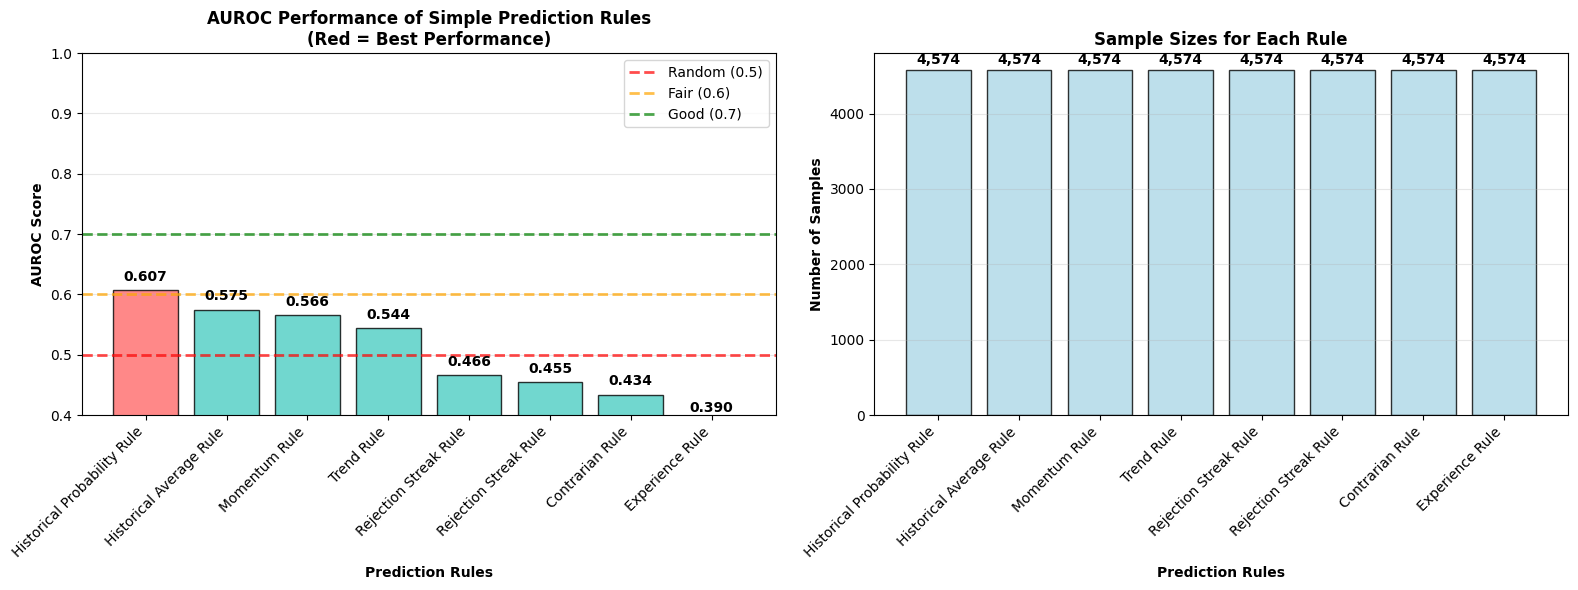


💾 Chart saved as: proposition_history_rules_comparison.png

DETAILED ANALYSIS

🎯 BEST RULE ANALYSIS:
Rule: Historical Probability Rule
AUROC: 0.6075
Accuracy: 0.6832
Sample Size: 4,574
True Approval Rate: 0.665
Predicted Approval Rate: 0.874

🟡 PROMISING: This rule shows fair predictive power!
   - AUROC ≥ 0.6 indicates some discrimination ability
   - Could be useful as part of a combined approach

🔄 GENERATING FINAL DATASET WITH BEST RULE...

📊 FINAL DATASET SUMMARY:
Total rows: 9,260
Rows with voting history: 4,867
Best rule: Historical Probability Rule
AUROC achieved: 0.6075

💾 FINAL DATASET SAVED!
Filename: proposition_history_predictions_historical_probability_rule.csv
Columns: ['id', 'data', 'propositionID', 'aprovacao', 'vote_count', 'last_vote_result', 'historical_approval_rate', 'approval_trend', 'rejection_streak', 'approval_streak', 'prediction', 'prediction_rule']

PROPOSITION HISTORY ANALYSIS COMPLETED!

📋 SUMMARY:
• We tested proposition voting history instead of relate

<Figure size 640x480 with 0 Axes>

In [41]:
# VISUALIZATION AND FINAL DATASET GENERATION
print("="*80)
print("CREATING VISUALIZATION AND FINAL DATASET")
print("="*80)

import matplotlib.pyplot as plt
import seaborn as sns

# Create visualization if we have valid results
if len(valid_results) > 0:
    # Create AUROC comparison chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: AUROC comparison
    rule_names = [name.split('(')[0].strip() for name in valid_results['rule_name']]  # Shorten names
    auroc_scores = valid_results['auroc']
    colors = ['#ff6b6b' if i == 0 else '#4ecdc4' for i in range(len(auroc_scores))]  # Highlight best
    
    bars = ax1.bar(range(len(rule_names)), auroc_scores, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('AUROC Performance of Simple Prediction Rules\n(Red = Best Performance)', fontweight='bold')
    ax1.set_xlabel('Prediction Rules', fontweight='bold')
    ax1.set_ylabel('AUROC Score', fontweight='bold')
    ax1.set_xticks(range(len(rule_names)))
    ax1.set_xticklabels(rule_names, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0.4, 1.0)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, auroc_scores)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Add horizontal line for reference
    ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Random (0.5)')
    ax1.axhline(y=0.6, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Fair (0.6)')
    ax1.axhline(y=0.7, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Good (0.7)')
    ax1.legend()
    
    # Plot 2: Sample size comparison
    sample_sizes = valid_results['n_samples']
    bars2 = ax2.bar(range(len(rule_names)), sample_sizes, color='lightblue', alpha=0.8, edgecolor='black')
    ax2.set_title('Sample Sizes for Each Rule', fontweight='bold')
    ax2.set_xlabel('Prediction Rules', fontweight='bold')
    ax2.set_ylabel('Number of Samples', fontweight='bold')
    ax2.set_xticks(range(len(rule_names)))
    ax2.set_xticklabels(rule_names, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars2, sample_sizes)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(sample_sizes)*0.01,
                 f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    plt.savefig('proposition_history_rules_comparison.png', dpi=300, bbox_inches='tight')
    print(f"\n💾 Chart saved as: proposition_history_rules_comparison.png")
    
    # Print detailed analysis
    print(f"\n" + "="*80)
    print("DETAILED ANALYSIS")
    print("="*80)
    
    best_rule = valid_results.iloc[0]
    
    print(f"\n🎯 BEST RULE ANALYSIS:")
    print(f"Rule: {best_rule['rule_name']}")
    print(f"AUROC: {best_rule['auroc']:.4f}")
    print(f"Accuracy: {best_rule['accuracy']:.4f}")
    print(f"Sample Size: {best_rule['n_samples']:,}")
    print(f"True Approval Rate: {best_rule['true_approval_rate']:.3f}")
    print(f"Predicted Approval Rate: {best_rule['predicted_approval_rate']:.3f}")
    
    # Performance interpretation
    auroc = best_rule['auroc']
    if auroc >= 0.7:
        print(f"\n🟢 EXCELLENT: This rule has good predictive power!")
        print(f"   - AUROC ≥ 0.7 indicates meaningful discrimination ability")
        print(f"   - This approach is worth pursuing further")
    elif auroc >= 0.6:
        print(f"\n🟡 PROMISING: This rule shows fair predictive power!")
        print(f"   - AUROC ≥ 0.6 indicates some discrimination ability")
        print(f"   - Could be useful as part of a combined approach")
    elif auroc >= 0.55:
        print(f"\n🟠 WEAK: This rule shows limited predictive power")
        print(f"   - AUROC ≥ 0.55 is slightly better than random")
        print(f"   - May need to be combined with other features")
    else:
        print(f"\n🔴 POOR: This rule has little predictive power")
        print(f"   - AUROC < 0.55 is close to random guessing")
        print(f"   - This approach may not be effective")
    
    # Generate final dataset with best rule if it's promising
    if auroc >= 0.55:  # Only generate if rule has some predictive power
        print(f"\n🔄 GENERATING FINAL DATASET WITH BEST RULE...")
        
        # Find the best rule function
        best_rule_name = best_rule['rule_name']
        best_rule_func = None
        
        for rule_func, rule_name in rules_to_test:
            if rule_name == best_rule_name:
                best_rule_func = rule_func
                break
        
        if best_rule_func:
            # Apply the best rule to create predictions
            predictions = []
            for idx, row in data_with_history.iterrows():
                if row['vote_count'] > 0:  # Only predict if we have history
                    try:
                        pred = best_rule_func(row)
                        predictions.append(pred)
                    except:
                        predictions.append(0.5)
                else:
                    predictions.append(0.5)  # Default for no history
            
            # Create final output DataFrame
            final_output = pd.DataFrame({
                'id': data_with_history['id'],
                'data': data_with_history['data'],
                'propositionID': data_with_history['propositionID'],
                'aprovacao': data_with_history['aprovacao'],
                'vote_count': data_with_history['vote_count'],
                'last_vote_result': data_with_history['last_vote_result'],
                'historical_approval_rate': data_with_history['historical_approval_rate'],
                'approval_trend': data_with_history['approval_trend'],
                'rejection_streak': data_with_history['rejection_streak'],
                'approval_streak': data_with_history['approval_streak'],
                'prediction': predictions,
                'prediction_rule': best_rule_name
            })
            
            # Save to CSV
            output_filename = f'proposition_history_predictions_{best_rule_name.lower().replace(" ", "_").replace("(", "").replace(")", "")}.csv'
            final_output.to_csv(output_filename, index=False)
            
            print(f"\n📊 FINAL DATASET SUMMARY:")
            print(f"Total rows: {len(final_output):,}")
            print(f"Rows with voting history: {(final_output['vote_count'] > 0).sum():,}")
            print(f"Best rule: {best_rule_name}")
            print(f"AUROC achieved: {auroc:.4f}")
            
            print(f"\n💾 FINAL DATASET SAVED!")
            print(f"Filename: {output_filename}")
            print(f"Columns: {list(final_output.columns)}")
        else:
            print(f"\n❌ Could not find the best rule function to apply")
    else:
        print(f"\n⚠️  Best rule AUROC ({auroc:.3f}) is too low to generate a useful dataset")
        print(f"   Consider trying different approaches or combining multiple features")

else:
    print("\n❌ No valid rules found to analyze or visualize")

print(f"\n" + "="*80)
print("PROPOSITION HISTORY ANALYSIS COMPLETED!")
print("="*80)
print("\n📋 SUMMARY:")
print("• We tested proposition voting history instead of related objects")
print("• Used simple prediction rules without machine learning")
print("• Evaluated multiple hypotheses: momentum, contrarian, historical, trends, streaks")
print("• Calculated AUROC for each rule to measure predictive power")
if len(valid_results) > 0:
    best_auroc = valid_results.iloc[0]['auroc']
    print(f"• Best performing rule achieved AUROC: {best_auroc:.4f}")
    if best_auroc >= 0.6:
        print("✅ Found meaningful predictive patterns!")
    elif best_auroc >= 0.55:
        print("⚠️  Found weak predictive patterns")
    else:
        print("❌ Limited predictive power found")
else:
    print("❌ No valid results obtained")
print("="*80)
